In [2]:
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0,'../ml')
from customlayers import balance_num_trainable_params, ReshapeLayer

In [3]:
class CNN(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self = balance_num_trainable_params(model=self, N_w=self.hparams['N_w'])
        
    def init_layers(self):
        self.layers = nn.ModuleList()
        self.kernel_sizes = self.hparams['kernel_sizes']
        self.bottleneck_size = self.hparams['bottleneck_size']
        #Layers
        self.layers.append(ReshapeLayer(output_shape=self.hparams['input_shape']))
        self.layers.append(nn.Conv2d(in_channels=self.hparams['input_shape'][0], out_channels=self.free_parameter, kernel_size=self.kernel_sizes[0], stride=self.kernel_sizes[0], bias=False))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(in_channels=self.free_parameter, out_channels=self.free_parameter, kernel_size=self.kernel_sizes[1], stride=self.kernel_sizes[1], bias=False))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(in_channels=self.free_parameter, out_channels=self.free_parameter, kernel_size=self.kernel_sizes[2], stride=self.kernel_sizes[2], bias=False))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(in_channels=self.free_parameter, out_channels=self.bottleneck_size, kernel_size=self.kernel_sizes[3], stride=self.kernel_sizes[3], bias=False))
        self.layers.append(ReshapeLayer(output_shape=(int(self.bottleneck_size),)))
        self.layers.append(nn.Linear(in_features=int(self.bottleneck_size), out_features=int(self.bottleneck_size)))
        self.layers.append(nn.ReLU())
        self.layers.append(ReshapeLayer(output_shape=(self.bottleneck_size,1,1)))
        self.layers.append(nn.ConvTranspose2d(self.bottleneck_size, self.free_parameter, kernel_size=self.kernel_sizes[4], stride=self.kernel_sizes[4], bias=False))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.ConvTranspose2d(self.free_parameter, self.free_parameter, kernel_size=self.kernel_sizes[5], stride=self.kernel_sizes[5], bias=False))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.ConvTranspose2d(self.free_parameter, self.free_parameter, kernel_size=self.kernel_sizes[6], stride=self.kernel_sizes[6], bias=False))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.ConvTranspose2d(self.free_parameter, 1, kernel_size=self.kernel_sizes[7], stride=self.kernel_sizes[7], bias=False))
        self.layers.append(ReshapeLayer(output_shape=self.hparams['output_shape']))           

    def forward(self, x):
        x0 = x
        x1 = self.layers[0](x0)
        x2 = self.layers[1](x1)
        x3 = self.layers[2](x2)
        x4 = self.layers[3](x3)
        x5 = self.layers[4](x4)
        x6 = self.layers[5](x5)
        x7 = self.layers[6](x6)
        x8 = self.layers[7](x7)
        x9 = self.layers[8](x8)
        x10 = self.layers[9](x9)
        x11 = self.layers[10](x10) + x9 if self.hparams['skipconnections']==True else self.layers[10](x10)
        x12 = self.layers[11](x11)
        x13 = self.layers[12](x12)
        x14 = self.layers[13](x13) + x7 if self.hparams['skipconnections']==True else self.layers[13](x13)
        x15 = self.layers[14](x14)
        x16 = self.layers[15](x15) + x5 if self.hparams['skipconnections']==True else self.layers[15](x15)
        x17 = self.layers[16](x16)
        x18 = self.layers[17](x17) + x3 if self.hparams['skipconnections']==True else self.layers[17](x17)
        x19 = self.layers[18](x18) + x1 if self.hparams['modeltype']=='model NGO' else self.layers[18](x18)
        x20 = self.layers[19](x19)
        y = x20
        return y

In [4]:
hparams = {}
hparams['N_w'] = 1000000
hparams['N_w_real'] = 0
hparams['skipconnections'] = True
hparams['modeltype'] = 'model NGO'
hparams['bottleneck_size'] = 20
hparams['dtype'] = torch.float64

Using device: cpu
[    1    16    81   256   625  1296  2401  4096  6561 10000]
Benchmarking size: 1x1


/tmp/ipykernel_375855/1633080585.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor[0,0] = torch.tensor(matrix, dtype=torch.float64)
/tmp/ipykernel_375855/1633080585.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor[0,0] = torch.tensor(matrix, dtype=torch.float32)


Benchmarking size: 16x16
Benchmarking size: 81x81
Benchmarking size: 256x256
Benchmarking size: 625x625
Benchmarking size: 1296x1296
Benchmarking size: 2401x2401
Benchmarking size: 4096x4096
Benchmarking size: 6561x6561
Benchmarking size: 10000x10000


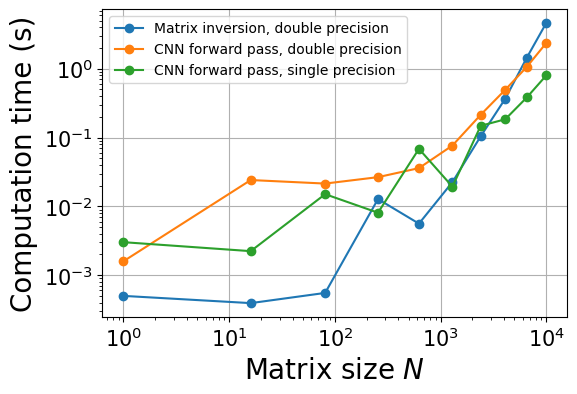

In [ ]:
# Measure execution time
def measure_time(func, *args):
    start = time.time()
    func(*args)
    end = time.time()
    return end - start

# Benchmarking setup
device = 'cpu'
print(f"Using device: {device}")

# k = np.array([1,2,4,8,16,32,64,128])
# matrix_sizes = 2*2*k**2
k = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
matrix_sizes = k**4

print(matrix_sizes)
cnn_times_single = []
cnn_times_double = []
inversion_times = []

i = 0
for size in matrix_sizes:
    print(f"Benchmarking size: {size}x{size}")
    # CNN Forward Pass
    hparams['input_shape'] = (1,size,size)
    hparams['output_shape'] = (size,size)
    # hparams['kernel_sizes'] = [2,2,k[i],k[i],k[i],k[i],2,2]
    hparams['kernel_sizes'] = [k[i],k[i],k[i],k[i],k[i],k[i],k[i],k[i]]

    # Matrix Inversion double precision
    matrix = torch.randn(size, size, dtype=torch.float64).to(device)
    inversion_time = measure_time(torch.linalg.inv, matrix)
    inversion_times.append(inversion_time)
    torch.cuda.empty_cache()

    # CNN forward pass double precision
    hparams['N_w_real'] = 0
    model = CNN(hparams).to(device)
    model = model.to(torch.float64)
    input_tensor = torch.randn(1, 1, size, size, dtype=torch.float64).to(device)
    input_tensor[0,0] = torch.tensor(matrix, dtype=torch.float64)
    cnn_time = measure_time(model, input_tensor)
    cnn_times_double.append(cnn_time)
    torch.cuda.empty_cache()

    # CNN forward pass single precision
    hparams['N_w_real'] = 0
    model = CNN(hparams).to(device)
    model = model.to(torch.float32)
    input_tensor = torch.randn(1, 1, size, size, dtype=torch.float32).to(device)
    input_tensor[0,0] = torch.tensor(matrix, dtype=torch.float32)
    cnn_time = measure_time(model, input_tensor)
    cnn_times_single.append(cnn_time)
    torch.cuda.empty_cache()
    i+=1

size_title = 25
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

ax.tick_params(axis='both', labelsize=size_ticklabels)
# Plotting results
ax.plot(matrix_sizes, inversion_times, label='Matrix inversion, double precision', marker='o')
ax.plot(matrix_sizes, cnn_times_double, label='CNN forward pass, double precision', marker='o')
ax.plot(matrix_sizes, cnn_times_single, label='CNN forward pass, single precision', marker='o')
ax.set_xlabel(r'Matrix size $N$', fontsize=size_axeslabels)
ax.set_ylabel('Computation time (s)', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.title('CNN Forward Pass vs. Matrix Inversion Time')
ax.legend()
ax.grid()

plt.savefig("CPU.svg", bbox_inches='tight')#, transparent=True)

plt.show()


Using device: cuda:1
[    1    16    81   256   625  1296  2401  4096  6561 10000 14641 20736]
Benchmarking size: 1x1


/tmp/ipykernel_501704/2676298507.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor[0,0] = torch.tensor(matrix, dtype=torch.float64)
/tmp/ipykernel_501704/2676298507.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor[0,0] = torch.tensor(matrix, dtype=torch.float32)


Benchmarking size: 16x16
Benchmarking size: 81x81
Benchmarking size: 256x256
Benchmarking size: 625x625
Benchmarking size: 1296x1296
Benchmarking size: 2401x2401
Benchmarking size: 4096x4096
Benchmarking size: 6561x6561
Benchmarking size: 10000x10000
Benchmarking size: 14641x14641
Benchmarking size: 20736x20736


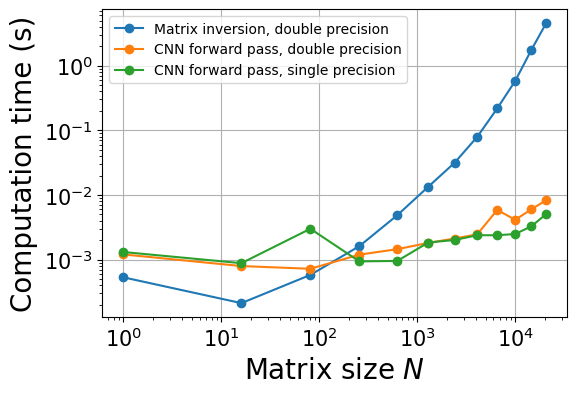

In [10]:
torch.cuda.empty_cache()

# Measure execution time
def measure_time(func, *args):
    start = time.time()
    func(*args)
    end = time.time()
    return end - start

# Benchmarking setup
device = 'cuda:1'
print(f"Using device: {device}")

# k = np.array([1,2,4,8,16,32,64,128])
# matrix_sizes = 2*2*k**2
k = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
matrix_sizes = k**4

print(matrix_sizes)
cnn_times_single = []
cnn_times_double = []
inversion_times = []

i = 0
for size in matrix_sizes:
    print(f"Benchmarking size: {size}x{size}")
    # CNN Forward Pass
    hparams['input_shape'] = (1,size,size)
    hparams['output_shape'] = (size,size)
    # hparams['kernel_sizes'] = [2,2,k[i],k[i],k[i],k[i],2,2]
    hparams['kernel_sizes'] = [k[i],k[i],k[i],k[i],k[i],k[i],k[i],k[i]]

    # Matrix Inversion double precision
    matrix = torch.randn(size, size, dtype=torch.float64).to(device)
    inversion_time = measure_time(torch.linalg.inv, matrix)
    inversion_times.append(inversion_time)
    torch.cuda.empty_cache()

    # CNN forward pass double precision
    hparams['N_w_real'] = 0
    model = CNN(hparams).to(device)
    model = model.to(torch.float64)
    input_tensor = torch.randn(1, 1, size, size, dtype=torch.float64).to(device)
    input_tensor[0,0] = torch.tensor(matrix, dtype=torch.float64)
    cnn_time = measure_time(model, input_tensor)
    cnn_times_double.append(cnn_time)
    torch.cuda.empty_cache()

    # CNN forward pass single precision
    hparams['N_w_real'] = 0
    model = CNN(hparams).to(device)
    model = model.to(torch.float32)
    input_tensor = torch.randn(1, 1, size, size, dtype=torch.float32).to(device)
    input_tensor[0,0] = torch.tensor(matrix, dtype=torch.float32)
    cnn_time = measure_time(model, input_tensor)
    cnn_times_single.append(cnn_time)
    torch.cuda.empty_cache()
    i+=1

size_title = 25
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

ax.tick_params(axis='both', labelsize=size_ticklabels)
# Plotting results
ax.plot(matrix_sizes, inversion_times, label='Matrix inversion, double precision', marker='o')
ax.plot(matrix_sizes, cnn_times_double, label='CNN forward pass, double precision', marker='o')
ax.plot(matrix_sizes, cnn_times_single, label='CNN forward pass, single precision', marker='o')
ax.set_xlabel(r'Matrix size $N$', fontsize=size_axeslabels)
ax.set_ylabel('Computation time (s)', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.title('CNN Forward Pass vs. Matrix Inversion Time')
ax.legend()
ax.grid()

plt.savefig("GPU.svg", bbox_inches='tight')#, transparent=True)

plt.show()


In [5]:
torch.cuda.empty_cache()

# Measure execution time
def measure_time(func, *args):
    start = time.time()
    func(*args)
    end = time.time()
    return end - start

# Benchmarking setup
device = 'cuda:1'
print(f"Using device: {device}")

# k = np.array([1,2,4,8,16,32,64,128])
# matrix_sizes = 2*2*k**2
k = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
matrix_sizes = k**4

print(matrix_sizes)
cnn_times_single = []
cnn_times_double = []
inversion_times = []

i = 0
for size in matrix_sizes:
    print(f"Benchmarking size: {size}x{size}")
    hparams['input_shape'] = (1,size,size)
    hparams['output_shape'] = (size,size)
    hparams['kernel_sizes'] = [k[i],k[i],k[i],k[i],k[i],k[i],k[i],k[i]]

    # Matrix Inversion double precision
    matrix = torch.randn(size, size, dtype=torch.float16).to(device)
    hparams['N_w_real'] = 0
    model = CNN(hparams).to(device)
    model = model.to(torch.float16)
    input_tensor = torch.randn(1, 1, size, size, dtype=torch.float16).to(device)
    input_tensor[0,0] = torch.tensor(matrix, dtype=torch.float16)
    cnn_time = measure_time(model, input_tensor)
    cnn_times_single.append(cnn_time)
    torch.cuda.empty_cache()
    i+=1

size_title = 25
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

ax.tick_params(axis='both', labelsize=size_ticklabels)
# Plotting results
# ax.plot(matrix_sizes, inversion_times, label='Matrix inversion, double precision', marker='o')
# ax.plot(matrix_sizes, cnn_times_double, label='CNN forward pass, double precision', marker='o')
ax.plot(matrix_sizes, cnn_times_single, label='CNN forward pass, single precision', marker='o')
ax.set_xlabel(r'Matrix size $N$', fontsize=size_axeslabels)
ax.set_ylabel('Computation time (s)', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.title('CNN Forward Pass vs. Matrix Inversion Time')
ax.legend()
ax.grid()

plt.savefig("singleprecision.svg", bbox_inches='tight')#, transparent=True)

plt.show()


Using device: cuda:1
[     1     16     81    256    625   1296   2401   4096   6561  10000
  14641  20736  28561  38416  50625  65536  83521 104976 130321 160000]
Benchmarking size: 1x1


/tmp/ipykernel_503221/3649140716.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor[0,0] = torch.tensor(matrix, dtype=torch.float16)


Benchmarking size: 16x16
Benchmarking size: 81x81
Benchmarking size: 256x256
Benchmarking size: 625x625
Benchmarking size: 1296x1296
Benchmarking size: 2401x2401
Benchmarking size: 4096x4096
Benchmarking size: 6561x6561
Benchmarking size: 10000x10000
Benchmarking size: 14641x14641
Benchmarking size: 20736x20736
Benchmarking size: 28561x28561
Benchmarking size: 38416x38416
Benchmarking size: 50625x50625


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [7]:
torch.cuda.empty_cache()